In [5]:
%run ../utils/commonImports.py
%run ../utils/tradingImports.py
%matplotlib inline

# Load Data

In [6]:
def calculate_EMA(history, col, time_period):
    return calculateTalib('EMA', {col: history[col].values}, {'timeperiod': time_period})


def add_EMA(df):
    df['blue'] = calculate_EMA(df, 'close', 8)
    df['green'] = calculate_EMA(df, 'close', 13)
    df['yellow'] = calculate_EMA(df, 'close', 21)
    df['red'] = calculate_EMA(df, 'close', 55)
    return df

In [7]:
def load_and_divide(db, table, from_date=None, to_date=None, train_ratio=0.5):
    data = load_trading_data(db, table, from_date, to_date)
    data = add_EMA(data)
    data_train, data_test = divide_train_and_test(data, train_ratio)
    return data, data_train, data_test


db = 'D:\\Dropbox\\My work\\krypl-project\\sqlite\\ploniex-chart-data\\USDT_BTC.db'
data, data_train, data_test = load_and_divide(db, 'chart_data', from_date='2017-01-01')
ohlc, ohlc_train, ohlc_test = data.copy(), data_train.copy(), data_test.copy()


features = ['red', 'yellow', 'green', 'blue']
data_manager_train = CurrencyDataManager(data_train['close'], data_train[features])
data_manager_test = CurrencyDataManager(data_test['close'], data_test[features])
wallet = {'usdt': 1000}
contract_pair = ContractPair.new('usdt', 'btc')

# Explore

In [4]:
correct_pattern = ohlc_train.query("red < yellow < green < blue").copy()

In [ ]:
correct_pattern.shape

In [ ]:
def ratio(df, c1, c2):
    return (df[c1] / df[c2]) - 1


def distplot(df, col, x_max):
    plt.figure(figsize=[12, 6])
    plt.title(col, fontproperties=title_font)
    sns.distplot(df[col])
    plt.xlim([0, x_max])

correct_pattern['ratioRY'] = ratio(correct_pattern, 'yellow', 'red')
correct_pattern['ratioYG'] = ratio(correct_pattern, 'green', 'yellow')
correct_pattern['ratioGB'] = ratio(correct_pattern, 'blue', 'green')

In [ ]:
distplot(correct_pattern, 'ratioRY', 0.015)
distplot(correct_pattern, 'ratioYG', 0.005)
distplot(correct_pattern, 'ratioGB', 0.005)

# Implementation

In [15]:
from modeling.strategy import Strategy

class HoldStrategy(Strategy):
    def __init__(self, exchange, data_manager, contract_pair, trade_size):
        super().__init__(exchange, data_manager, contract_pair, trade_size, 0., 0.)    
    
    def trade(self):
        while self.data_manager.has_tick():            
            history, price = self.data_manager.tick(1)
            
            if history.shape[0] == 0:
                self.buy(price)
            else:
                continue
        
        if self.opened:
            self.sell_all(price)

In [9]:
from modeling.strategy import Strategy
from itertools import permutations

ORDERS = list(permutations('BGYR', 4))


class CustomStrategy(Strategy):
    def __init__(self, exchange, data_manager, contract_pair, trade_size, willing_loss, target_profit, params):
        super().__init__(exchange, data_manager, contract_pair, trade_size, willing_loss, target_profit)
        self.history_len = 1
        self.params = params
    
    def has_correct_order(self, _type, red, yellow, green, blue):
        order = self.params['order_' + _type]
        d = {'R': red, 'Y': yellow, 'G': green, 'B': blue}
        l = [d[order[i]] for i in range(len(order))]
        for i in range(len(l)-1):
            if l[i] < l[i+1]:
                return False
        
        thresholds = [self.params[f'r{i}_{_type}'] for i in range(1, len(order))]
        
        def ratio(x, y):
            return (x / y) - 1
        
        for i in range(len(l)-1):
            if ratio(l[i], l[i+1]) > thresholds[i]:
                return False
        
        return True
    
    
    def trade(self):
        after_sell = False
        while self.data_manager.has_tick():            
            history, price = self.data_manager.tick(self.history_len)
            
            if history.shape[0] == 0:
                continue
            
            red, yellow, green, blue = history[0]
            if np.isnan(red):
                continue
            
            if not self.opened and not after_sell and self.has_correct_order('buy', red, yellow, green, blue):
                self.buy(price)
                price_bought = price
            elif self.opened and self.is_risky(price_bought, price):
                self.sell_all(price)
                after_sell = True
            elif self.opened and self.is_target_satisfied(price_bought, price):
                self.sell_all(price)
                after_sell = True
            elif self.opened and self.has_correct_order('sell', red, yellow, green, blue):
                self.sell_all(price)
                after_sell = True
        
        if self.opened:
            self.sell_all(price)

In [10]:
ORDERS

[('B', 'G', 'Y', 'R'),
 ('B', 'G', 'R', 'Y'),
 ('B', 'Y', 'G', 'R'),
 ('B', 'Y', 'R', 'G'),
 ('B', 'R', 'G', 'Y'),
 ('B', 'R', 'Y', 'G'),
 ('G', 'B', 'Y', 'R'),
 ('G', 'B', 'R', 'Y'),
 ('G', 'Y', 'B', 'R'),
 ('G', 'Y', 'R', 'B'),
 ('G', 'R', 'B', 'Y'),
 ('G', 'R', 'Y', 'B'),
 ('Y', 'B', 'G', 'R'),
 ('Y', 'B', 'R', 'G'),
 ('Y', 'G', 'B', 'R'),
 ('Y', 'G', 'R', 'B'),
 ('Y', 'R', 'B', 'G'),
 ('Y', 'R', 'G', 'B'),
 ('R', 'B', 'G', 'Y'),
 ('R', 'B', 'Y', 'G'),
 ('R', 'G', 'B', 'Y'),
 ('R', 'G', 'Y', 'B'),
 ('R', 'Y', 'B', 'G'),
 ('R', 'Y', 'G', 'B')]

In [19]:
def create_strategy(data_manager_p, param_array):
#     params = {
#         'order_buy': ORDERS[int(param_array[0])],
#         'r1_buy': param_array[1],
#         'r2_buy': param_array[2],
#         'r3_buy': param_array[3],
#         'order_sell': ORDERS[int(param_array[4])],
#         'r1_sell': param_array[5],
#         'r2_sell': param_array[6],
#         'r3_sell': param_array[7],
#     }
    
    params = {
        'order_buy': ORDERS[0],
        'r1_buy': param_array[0],
        'r2_buy': param_array[1],
        'r3_buy': param_array[2],
        'order_sell': ORDERS[7],
        'r1_sell': param_array[3],
        'r2_sell': param_array[4],
        'r3_sell': param_array[5],
    }
    
    data_manager = deepcopy(data_manager_p)
    exchange = BackTestExchange(data_manager, deepcopy(wallet), 0.0025)
    strategy = CustomStrategy(exchange, data_manager, contract_pair, 100, willing_loss=0.05, target_profit=1, params=params)
    return data_manager, exchange, strategy


def hold_stats(data_manager_p):
    data_manager = deepcopy(data_manager_p)
    exchange = BackTestExchange(data_manager, deepcopy(wallet), 0.0025)
    strategy = HoldStrategy(exchange, data_manager, contract_pair, 100)
    strategy.trade()
    return strategy.stats('usdt').report()

# Learning

In [17]:
def create_train_strategy(param_array):
    return create_strategy(data_manager_train, param_array)

In [22]:
hold_stats_train = hold_stats(data_manager_train)
hold_stats_train

,usdt
startAmount,"1,000.0000"
numberOfTrades,1.0000
totalProfit,282.2111
avgProfit,282.2111
winPercentage,100.0000
avgWinTrade,282.2111
avgLossTrade,0.0000
profitFactor,inf
maxDrawdown,0.0000


In [40]:
data_manager, exchange, strategy = create_train_strategy([0, 0.005, 0.001, 0.0015, 10, 0.005, 0.001, 0.0015,])
strategy.trade()
r = strategy.stats('usdt').report()
r

,usdt
startAmount,"1,000.0000"
numberOfTrades,1.0000
totalProfit,-5.1266
avgProfit,-5.1266
winPercentage,0.0000
avgWinTrade,0.0000
avgLossTrade,-5.1266
profitFactor,0.0000
maxDrawdown,0.5127


In [69]:
from random import Random
from time import time
import inspyred

def main(prng=None, display=False): 
    if prng is None:
        prng = Random()
        prng.seed(time()) 
    
    problem = inspyred.benchmarks.Binary(inspyred.benchmarks.Schwefel(2), 
                                         dimension_bits=30)
    ea = inspyred.ec.GA(prng)
    ea.terminator = inspyred.ec.terminators.evaluation_termination
    final_pop = ea.evolve(generator=problem.generator,
                          evaluator=problem.evaluator,
                          pop_size=100,
                          maximize=problem.maximize,
                          bounder=problem.bounder,
                          max_evaluations=30000, 
                          num_elites=1)
                          
    if display:
        best = max(final_pop)
        print('Best Solution: \n{0}'.format(str(best)))
    return ea

In [70]:
main(display=True)

Best Solution: 
[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0] : 0.0003665951078346552


In [74]:
1 / 10**10

1e-10

In [93]:
from scipy.optimize import minimize, brute
import sys
from math import log10

MIN_FLOAT = 1 / 10**10

def optim_val(stats, hold_stats):
    return (hold_stats.loc['totalProfit', 'usdt'] - stats.loc['totalProfit', 'usdt']) * (log10(stats.loc['numberOfTrades', 'usdt'] + 1) + 1)

def f(x):
    data_manager, exchange, strategy = create_train_strategy(x)
    strategy.trade()
    r = strategy.stats('usdt').report()
    optimization_value = optim_val(r, hold_stats_train)
    sys.stdout.write(f"\r{x}, {optimization_value}")
    sys.stdout.flush()
    return optimization_value

rranges = [slice(0, 1, 1)] + [slice(0, 1, 0.1)]*3
rranges = rranges + rranges

# best_params = minimize(f, [0.001]*6, method="Nelder-Mead")
best_params = minimize(f, [0.001]*6, method="Powell")


# best_params = brute(f, rranges)
# best_params

[2.619034e+00 1.000000e-03 1.000000e-03 1.000000e-03 1.000000e-03
[1.61903397e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
[2.00099998e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
[2.23706797e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
[2.382966e+00 1.000000e-03 1.000000e-03 1.000000e-03 1.000000e-03
[2.47313595e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
[2.52886405e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
[2.5633059e+00 1.0000000e-03 1.0000000e-03 1.0000000e-03 1.0000000e-03
[2.58892896e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
[2.58892896e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
[2.58892896e+00 1.00100000e+00 1.00000000e-03 1.00000000e-03
[ 2.58892896e+00 -1.61703400e+00  1.00000000e-03  1.00000000e-03
[ 2.58892896e+00 -2.77003060e+00  1.00000000e-03  1.00000000e-03
[ 2.58892896e+00 -1.61703400e+00  1.00000000e-03  1.00000000e-03
[ 2.58892896e+00 -9.99000025e-01  1.00000000e-03  1.00000000e-03
[ 2.58892896e+00 -6.17034016e-01  1.00000000e-03 

In [94]:
best_params

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 6.69737631e+00, -4.91009859e-03,  6.69737631e+00,
         6.69737631e+00,  6.69737631e+00,  6.69737631e+00]])
     fun: 282.21113990033655
 message: 'Optimization terminated successfully.'
    nfev: 174
     nit: 2
  status: 0
 success: True
       x: array([ 2.92065684e+01, -1.85143930e-02,  2.92065684e+01,  2.92065684e+01,
        2.92065684e+01,  2.92065684e+01])

In [95]:
data_manager, exchange, strategy = create_train_strategy(best_params['x'])
strategy.trade()
r = strategy.stats('usdt').report()
print(optim_val(r, hold_stats_train))
r

282.21113990033655


,usdt
startAmount,"1,000.0000"
numberOfTrades,0.0000
totalProfit,0.0000
avgProfit,0.0000
winPercentage,0.0000
avgWinTrade,0.0000
avgLossTrade,0.0000
profitFactor,inf
maxDrawdown,0.0000


# Look on transactions

In [50]:
len(strategy.exchange.transactions)

2

In [51]:
winningTransactions = []
for i in range(int(len(strategy.exchange.transactions) / 2)):
    t1, t2 = strategy.exchange.transactions[i:i+2]
    if t1['amount'] < t2['amount']:
        winningTransactions += [t1, t2]

In [52]:
len(winningTransactions)

0

In [53]:
strategy.exchange.transactions[2:4]

[]

<IPython.core.display.Javascript object>


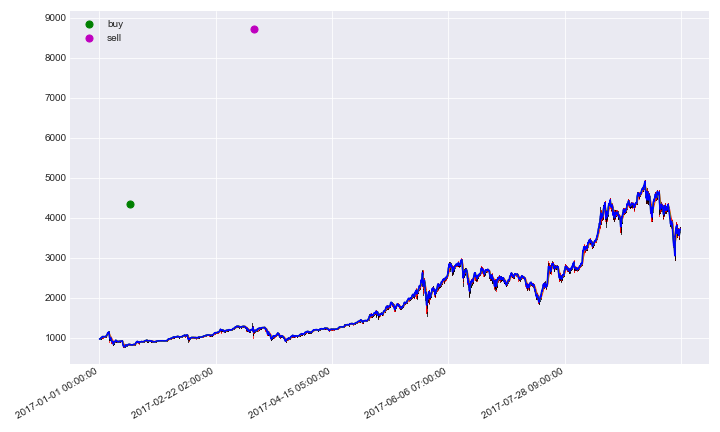

In [54]:
%matplotlib notebook
plot_transactions(ohlc_train, strategy.exchange.transactions[:])

for c in ['red', 'yellow', 'green', 'blue']:
    plt.plot(range(ohlc_train.shape[0]), ohlc_train[c], c=c)

# Evaluate

In [46]:
def create_test_strategy(param_array):
    return create_strategy(data_manager_test, param_array)

In [55]:
data_manager, exchange, strategy = create_test_strategy(best_params['x'])
strategy.trade()
strategy.stats('usdt').report()

,usdt
startAmount,"1,000.0000"
numberOfTrades,1.0000
totalProfit,100.4736
avgProfit,100.4736
winPercentage,100.0000
avgWinTrade,100.4736
avgLossTrade,0.0000
profitFactor,inf
maxDrawdown,0.0000


<IPython.core.display.Javascript object>


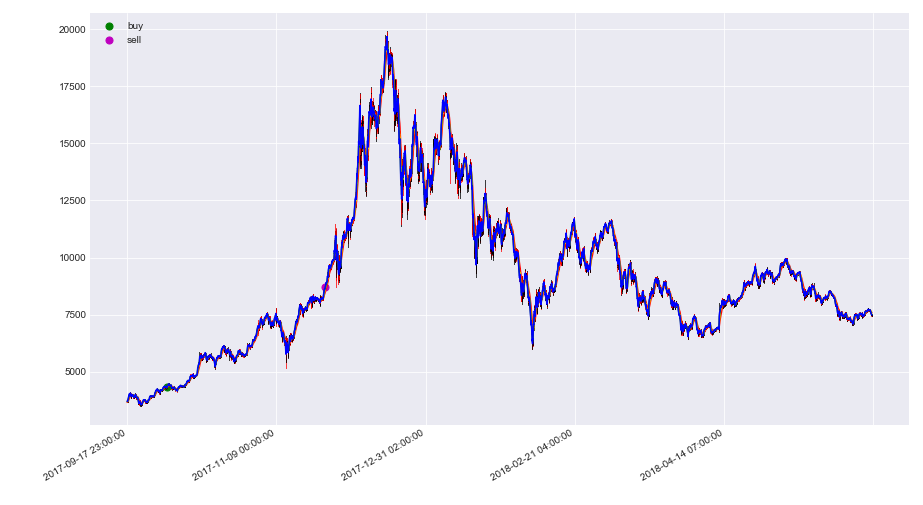

In [57]:
plot_transactions(ohlc_test, strategy.exchange.transactions[:])

for c in ['red', 'yellow', 'green', 'blue']:
    plt.plot(range(ohlc_test.shape[0]), ohlc_test[c], c=c)